<a href="https://colab.research.google.com/github/simsekergun/ENEE691/blob/main/week12/CNN_Classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $\color{ForestGreen}{\text{CNN Models for Classification}}$

In [ ]:
# Importing basic libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time

# Importing some basic modules in torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import BatchSampler, Dataset, DataLoader

import torch
import torchvision
from torchvision import transforms

# Importing 'Subset' from torch ('Subset' conveniently allows to take a subset of a given dataset.)
from torch.utils.data import Subset

In [ ]:
MNIST_train = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
MNIST_test = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

print('Size of MNIST train =', len(MNIST_train))
print('Size of MNIST test =', len(MNIST_test))

100%|██████████| 9912422/9912422 [00:00<00:00, 81275264.29it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 7070314.24it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24764441.90it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13656293.02it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Size of MNIST train = 60000
Size of MNIST test = 10000


In [ ]:
def moveTo(obj, device):
    if isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    elif hasattr(obj, "to"):
        return obj.to(device)
    else:
        return obj

In [ ]:
def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using. 

        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)
        
        y_hat = model(inputs) #this just computed f_Θ(x(i))

        # Compute loss.
        loss = loss_func(y_hat, labels)
         
        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()
    
    y_pred = np.asarray(y_pred)
    
    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )  # For regression 
        except:
            results[prefix + " " + name].append(score_func(y_true, np.argmax(y_pred, axis=1))) # For classification
    return end-start #time spent on epoch

In [ ]:
def train_simple_network_alt(model, optimizer, loss_func, eta, train_loader, test_loader=None, score_funcs=None, 
                         epochs=50, device="cpu"):
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    if score_funcs is not None:
        for eval_score in score_funcs:
            to_track.append("train " + eval_score )
            if test_loader is not None:
                to_track.append("test " + eval_score )
        
    total_train_time = 0              #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
        
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(1, epochs+1), desc="Epoch"):
        model = model.train()#Put our model in training mode
        
        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, 
                                      prefix="train", desc="Training")  
        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )
        
        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", 
                          desc="Testing")
                
    return pd.DataFrame.from_dict(results)

In [ ]:
percent_cap = 7  # We only use 7 percent of the MNIST data

subset_train = Subset(MNIST_train, indices=range((len(MNIST_train)*percent_cap)//100))
subset_test = Subset(MNIST_test, indices=range((len(MNIST_test)*percent_cap)//100))

print('Number of samples in the train subset =', len(subset_train))
print('Number of samples in the test subset =', len(subset_test))

Number of samples in the train subset = 4200
Number of samples in the test subset = 700


In [ ]:
# Let's see how classes (different digits) are distributed in the 'subset_train' 

y = [subset_train[i][1] for i in range(len(subset_train))]

count = 0
for j in range(10):
    z = [1 if a==j else 0 for a in y]
    count += sum(z)
    print('The number of digit %d in the train subset is: %d' %(j, sum(z)))
print('Total number of instances in the train subset: ', count)

The number of digit 0 in the train subset is: 396
The number of digit 1 in the train subset is: 472
The number of digit 2 in the train subset is: 415
The number of digit 3 in the train subset is: 410
The number of digit 4 in the train subset is: 452
The number of digit 5 in the train subset is: 372
The number of digit 6 in the train subset is: 423
The number of digit 7 in the train subset is: 451
The number of digit 8 in the train subset is: 390
The number of digit 9 in the train subset is: 419
Total number of instances in the train subset:  4200


In [ ]:
# Loading the data using 'DataLoader'

train_loader = DataLoader(subset_train, shuffle=True) 
test_loader = DataLoader(subset_test)

In [ ]:
D = 28*28       # Number of features
K = 10          # Number of classes
n_neuron = 256  # Number of neurons
eta = 0.001     # Learning rate

#del lin_model

lin_model = nn.Sequential(
    nn.Flatten(),                # Coverting tensors with structure (B, C, W, H) to (B,D)=(B, C*W*H) 
    nn.Linear(D, n_neuron),      # One linear hidden layer from inputs to n_neuron neurons
    nn.ReLU(),                   # Applying activation function
    nn.Linear(n_neuron, K),      # one linear layer to get from n_neuron neurons to K classes
    nn.Softmax(dim=1),           # Applying Softmax to convert scores to a discrete probability distribution
)

optimizer = torch.optim.Adam(lin_model.parameters(), lr=eta)  # Adam optimizer

loss_func = nn.CrossEntropyLoss()   # Loss function is cross entropy 

In [ ]:
# Training the model and collect the relevant performance metrics 

lin_results = train_simple_network_alt(lin_model, optimizer, loss_func, eta, train_loader, test_loader, 
                                       score_funcs={'accuracy': accuracy_score}, epochs=20)

Streaming output truncated to the last 5000 lines.
Training: 100%|█████████▉| 4185/4200 [00:26<00:00, 147.47it/s]
                                                              
Training: 100%|█████████▉| 4198/4200 [00:25<00:00, 134.71it/s]
                                                              
Training: 100%|█████████▉| 4188/4200 [00:26<00:00, 156.58it/s]
                                                              
Training: 100%|█████████▉| 4191/4200 [00:26<00:00, 162.71it/s]
                                                              
Training: 100%|█████████▉| 4190/4200 [00:27<00:00, 151.48it/s]
                                                              
Training: 100%|█████████▉| 4190/4200 [00:28<00:00, 151.59it/s]
                                                              
Training: 100%|█████████▉| 4189/4200 [00:29<00:00, 148.71it/s]
                                                              
Training: 100%|█████████▉| 4186/4200 [00:30<00:00, 144.36it/s]
    

In [ ]:
lin_results

,epoch,total time,train loss,test loss,train accuracy,test accuracy
0,1,29.365892,1.652648,1.609781,0.821667,0.864286
1,2,53.557273,1.558505,1.571729,0.906905,0.894286
2,3,78.156543,1.537021,1.577269,0.925476,0.887143
3,4,103.786226,1.525276,1.574002,0.935952,0.885714
4,5,130.448714,1.517991,1.570063,0.944048,0.890000
5,6,156.254219,1.508659,1.561184,0.952619,0.900000
6,7,182.555679,1.507194,1.554728,0.954762,0.908571
7,8,209.435853,1.504533,1.552381,0.957619,0.911429
8,9,237.227494,1.496341,1.556241,0.964762,0.902857
9,10,265.473227,1.494345,1.560369,0.966905,0.897143


In [ ]:
D = 28*28     # Number of features
K = 10        # Number of classes
C = 1         # Number of channels (for colors)
F = 16        # Number of filters
ker = 3       # Filter size
eta = 0.001   # Learning rate

#del cnn_class_model

cnn_class_model = nn.Sequential(
    # A convolutional layer from C channels to F channels 
    # with a square kernel of size ker with appropriate padding
    nn.Conv2d(C, F, ker, padding=ker//2),    
    nn.ReLU(),          # Applying activation function
    nn.Flatten(),       # Coverting tensors with structure (B, C, W, H) to (B,D)=(B, C*W*H)
    nn.Linear(F*D, K),  # A linear layer from F*D neurons to K classes
    nn.Softmax(dim=1),  # Applying Softmax to convert scores to a discrete probability distribution
)    

optimizer = torch.optim.Adam(cnn_class_model.parameters(), lr=eta)  # Adam optimizer

loss_func = nn.CrossEntropyLoss()  # Loss function is cross entropy

In [ ]:
# Training the model and collect the relevant performance metrics 

cnn_class_results = train_simple_network_alt(cnn_class_model, optimizer, loss_func, eta, train_loader, 
                    test_loader, score_funcs={'accuracy': accuracy_score}, epochs=20)

Training: 100%|█████████▉| 4192/4200 [00:19<00:00, 200.45it/s]
                                                              
Training: 100%|█████████▉| 4188/4200 [00:23<00:00, 174.58it/s]
                                                              
Training: 100%|█████████▉| 4189/4200 [00:21<00:00, 216.35it/s]
                                                              
Training: 100%|█████████▉| 4190/4200 [00:20<00:00, 233.91it/s]
                                                              
Training: 100%|█████████▉| 4194/4200 [00:20<00:00, 208.53it/s]
                                                              
Training: 100%|█████████▉| 4199/4200 [00:20<00:00, 264.60it/s]
                                                              
Training: 100%|█████████▉| 4192/4200 [00:18<00:00, 237.19it/s]
                                                              
Training: 100%|█████████▉| 4188/4200 [00:18<00:00, 204.00it/s]
                                                       

In [ ]:
cnn_class_results

,epoch,total time,train loss,test loss,train accuracy,test accuracy
0,1,19.764231,1.703171,1.592844,0.758810,0.872857
1,2,43.013048,1.546717,1.563254,0.918095,0.900000
2,3,65.070193,1.513726,1.529520,0.951190,0.937143
3,4,85.605466,1.501926,1.528685,0.961905,0.937143
4,5,106.031814,1.489453,1.519522,0.972619,0.947143
5,6,126.222701,1.483546,1.512920,0.978095,0.950000
6,7,144.920125,1.479406,1.514237,0.982619,0.948571
7,8,163.488135,1.478116,1.522223,0.983810,0.938571
8,9,182.548305,1.475559,1.534702,0.986429,0.925714
9,10,202.122228,1.474033,1.517686,0.987619,0.944286


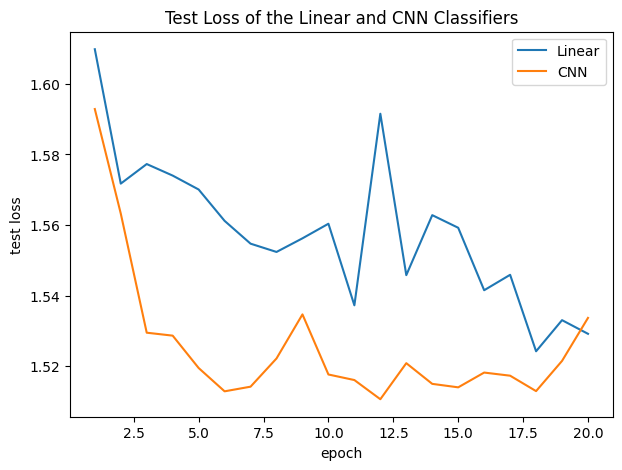

In [ ]:
sns.lineplot(x='epoch', y='test loss', data=lin_results, label='Linear')
sns.lineplot(x='epoch', y='test loss', data=cnn_class_results, label='CNN')
plt.title('Test Loss of the Linear and CNN Classifiers')
plt.gcf().set_size_inches(7, 5)
plt.show()

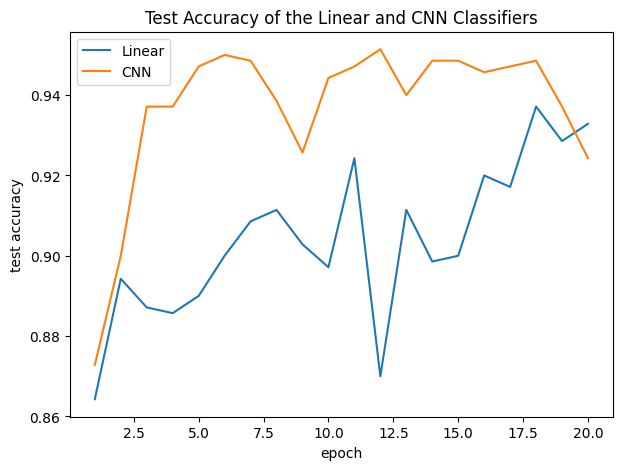

In [ ]:
sns.lineplot(x='epoch', y='test accuracy', data=lin_results, label='Linear')
sns.lineplot(x='epoch', y='test accuracy', data=cnn_class_results, label='CNN')
plt.title('Test Accuracy of the Linear and CNN Classifiers')
plt.gcf().set_size_inches(7, 5)
plt.show()

In [ ]:
D = 28*28     # Number of features
K = 10        # Number of classes
C = 1         # Number of channels
F = 16        # Number of filters
ker = 5       # Filter size
eta = 0.001   # Learning rate

#del cnn_class_model_2

cnn_class_model_2 = nn.Sequential(
    nn.Conv2d(C, F, ker, padding=ker//2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(F*D, K),
    nn.Softmax(dim=1),
)    

optimizer = torch.optim.Adam(cnn_class_model_2.parameters(), lr=eta)  # Adam optimizer

loss_func = nn.CrossEntropyLoss() 

In [ ]:
# Training the model and collect the relevant performance metrics 

cnn_class_results_2 = train_simple_network_alt(cnn_class_model_2, optimizer, loss_func, eta, train_loader, 
                    test_loader, score_funcs={'accuracy': accuracy_score}, epochs=20)

Streaming output truncated to the last 5000 lines.
Training: 100%|█████████▉| 4195/4200 [00:18<00:00, 128.95it/s]
                                                              
Training:  99%|█████████▉| 4176/4200 [00:18<00:00, 240.15it/s]
                                                              
Training: 100%|█████████▉| 4182/4200 [00:19<00:00, 230.05it/s]
                                                              
Training: 100%|█████████▉| 4198/4200 [00:19<00:00, 226.53it/s]
                                                              
Training: 100%|█████████▉| 4194/4200 [00:21<00:00, 168.80it/s]
                                                              
Training: 100%|█████████▉| 4196/4200 [00:21<00:00, 199.38it/s]
                                                              
Training: 100%|█████████▉| 4198/4200 [00:21<00:00, 154.66it/s]
                                                              
Training: 100%|█████████▉| 4182/4200 [00:21<00:00, 190.75it/s]
    

In [ ]:
cnn_class_results_2

,epoch,total time,train loss,test loss,train accuracy,test accuracy
0,1,18.065996,1.717924,1.566402,0.744762,0.897143
1,2,36.356225,1.529854,1.524797,0.931667,0.941429
2,3,55.475314,1.509156,1.541673,0.953571,0.915714
3,4,75.336411,1.500543,1.530269,0.961667,0.935714
4,5,96.476955,1.496281,1.518534,0.964762,0.944286
5,6,117.609629,1.489080,1.524574,0.972381,0.934286
6,7,139.359685,1.482702,1.515411,0.977857,0.944286
7,8,161.211827,1.480268,1.514989,0.981667,0.947143
8,9,184.777653,1.477294,1.517328,0.984286,0.942857
9,10,210.214039,1.476147,1.517997,0.985000,0.944286


In [ ]:
D = 28*28     # Number of features
K = 10        # Number of classes
C = 1         # Number of channels
F = 16        # Number of filters
ker_l = 5     # Filter length
ker_w = 3     # Filter width 
eta = 0.001   # Learning rate

#del cnn_class_model_3

cnn_class_model_3 = nn.Sequential(
    nn.Conv2d(C, F, (ker_l, ker_w), padding=(ker_l//2, ker_w//2)),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(F*D, K),
    nn.Softmax(dim=1),
)    

optimizer = torch.optim.Adam(cnn_class_model_3.parameters(), lr=eta)  # Adam optimizer

loss_func = nn.CrossEntropyLoss()

In [ ]:
# Training the model and collect the relevant performance metrics 

cnn_class_results_3 = train_simple_network_alt(cnn_class_model_3, optimizer, loss_func, eta, train_loader, 
                    test_loader, score_funcs={'accuracy': accuracy_score}, epochs=20)

Streaming output truncated to the last 5000 lines.
Training: 100%|█████████▉| 4192/4200 [00:20<00:00, 158.24it/s]
                                                              
Training: 100%|█████████▉| 4184/4200 [00:21<00:00, 242.03it/s]
                                                              
Training: 100%|█████████▉| 4198/4200 [00:18<00:00, 211.52it/s]
                                                              
Training: 100%|█████████▉| 4182/4200 [00:19<00:00, 216.73it/s]
                                                              
Training: 100%|█████████▉| 4197/4200 [00:21<00:00, 178.39it/s]
                                                              
Training: 100%|█████████▉| 4188/4200 [00:21<00:00, 193.00it/s]
                                                              
Training: 100%|█████████▉| 4187/4200 [00:24<00:00, 167.08it/s]
                                                              
Training: 100%|█████████▉| 4192/4200 [00:26<00:00, 141.54it/s]
    

In [ ]:
cnn_class_results_3

,epoch,total time,train loss,test loss,train accuracy,test accuracy
0,1,18.017773,2.353755,2.355436,0.107381,0.105714
1,2,36.820500,2.353531,2.355436,0.107619,0.105714
2,3,56.422832,2.353531,2.355436,0.107619,0.105714
3,4,77.146315,2.353531,2.355436,0.107619,0.105714
4,5,98.878684,2.353531,2.355436,0.107619,0.105714
5,6,117.412886,2.353531,2.355436,0.107619,0.105714
6,7,137.376738,2.353531,2.355436,0.107619,0.105714
7,8,158.855709,2.353531,2.355436,0.107619,0.105714
8,9,180.775243,2.353531,2.355436,0.107619,0.105714
9,10,205.384491,2.353531,2.355436,0.107619,0.105714


In [ ]:
D = 28*28     # Number of features
K = 10        # Number of classes
C = 1         # Number of channels
F = 16        # Number of filters
ker = 3       # Filter size
eta = 0.001   # Learning rate

#del cnn_class_model_4

cnn_class_model_4 = nn.Sequential(
    nn.Conv2d(C, F, ker, padding=ker//2),   # CNN layer 1 from C channels to F 
    nn.ReLU(),
    nn.Conv2d(F, F, ker, padding=ker//2),   # CNN layer 2 from F channels to F
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(F*D, K),
    nn.Softmax(dim=1),
)    

optimizer = torch.optim.Adam(cnn_class_model_4.parameters(), lr=eta)  # Adam optimizer

loss_func = nn.CrossEntropyLoss()

In [ ]:
# Training the model and collect the relevant performance metrics 

cnn_class_results_4 = train_simple_network_alt(cnn_class_model_4, optimizer, loss_func, eta, train_loader, 
                    test_loader, score_funcs={'accuracy': accuracy_score}, epochs=20)

Streaming output truncated to the last 5000 lines.
Training: 100%|█████████▉| 4194/4200 [00:33<00:00, 135.47it/s]
                                                              
Training: 100%|██████████| 4200/4200 [00:32<00:00, 142.66it/s]
                                                              
Training: 100%|█████████▉| 4192/4200 [00:34<00:00, 119.44it/s]
                                                              
Training: 100%|█████████▉| 4189/4200 [00:34<00:00, 131.66it/s]
                                                              
Training: 100%|██████████| 4200/4200 [00:36<00:00, 100.19it/s]
                                                              
Training: 100%|█████████▉| 4191/4200 [00:37<00:00, 121.56it/s]
                                                              
Training: 100%|█████████▉| 4196/4200 [00:37<00:00, 111.47it/s]
                                                              
Training: 100%|█████████▉| 4198/4200 [00:37<00:00, 123.22it/s]
    

In [ ]:
cnn_class_results_4

,epoch,total time,train loss,test loss,train accuracy,test accuracy
0,1,21.782734,1.671234,1.617544,0.792143,0.840000
1,2,44.834275,1.544258,1.571318,0.917143,0.888571
2,3,69.146464,1.519943,1.536640,0.941905,0.921429
3,4,96.092214,1.509146,1.538484,0.952619,0.921429
4,5,127.071136,1.514142,1.567058,0.947143,0.894286
5,6,159.226019,1.509536,1.523661,0.950952,0.938571
6,7,192.592134,1.494619,1.546214,0.966905,0.915714
7,8,225.586626,1.507115,1.567666,0.954048,0.892857
8,9,260.539742,1.504334,1.526978,0.956905,0.934286
9,10,295.591896,1.498434,1.528485,0.962381,0.931429


In [ ]:
sns.lineplot(x='epoch', y='test loss', data=lin_results, label='Linear')
sns.lineplot(x='epoch', y='test loss', data=cnn_class_results, label='CNN')
sns.lineplot(x='epoch', y='test loss', data=cnn_class_results_2, label='CNN-2')
sns.lineplot(x='epoch', y='test loss', data=cnn_class_results_3, label='CNN-3')
sns.lineplot(x='epoch', y='test loss', data=cnn_class_results_4, label='CNN-4')
plt.title('Test Loss of the Linear and CNN Classifiers')
plt.gcf().set_size_inches(10, 7)
plt.show()

In [ ]:
sns.lineplot(x='epoch', y='train accuracy', data=lin_results[5:], label='Linear')
sns.lineplot(x='epoch', y='train accuracy', data=cnn_class_results[5:], label='CNN')
sns.lineplot(x='epoch', y='train accuracy', data=cnn_class_results_2[5:], label='CNN-2')
sns.lineplot(x='epoch', y='train accuracy', data=cnn_class_results_3[5:], label='CNN-3')
sns.lineplot(x='epoch', y='train accuracy', data=cnn_class_results_4[5:], label='CNN-4')
plt.title('Train Accuracy of the Linear and CNN Classifiers')
plt.gcf().set_size_inches(10, 7)
plt.show()

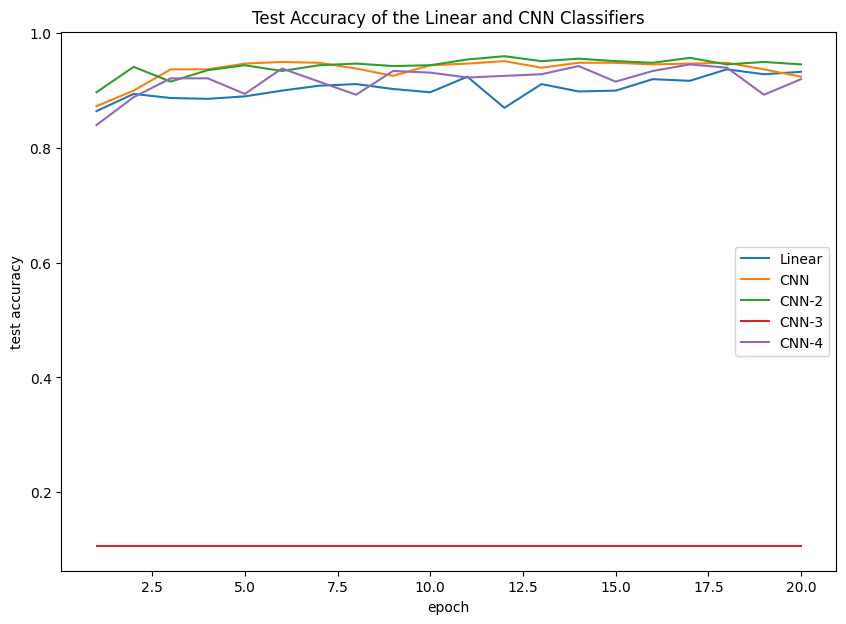

In [28]:
sns.lineplot(x='epoch', y='test accuracy', data=lin_results, label='Linear')
sns.lineplot(x='epoch', y='test accuracy', data=cnn_class_results, label='CNN')
sns.lineplot(x='epoch', y='test accuracy', data=cnn_class_results_2, label='CNN-2')
sns.lineplot(x='epoch', y='test accuracy', data=cnn_class_results_3, label='CNN-3')
sns.lineplot(x='epoch', y='test accuracy', data=cnn_class_results_4, label='CNN-4')
plt.title('Test Accuracy of the Linear and CNN Classifiers')
plt.gcf().set_size_inches(10, 7)
plt.show()